# Setup

**Imports**

In [1]:
import numpy as np
import matplotlib.pyplot as plt

**Utility functions**

In [2]:
def fig_ax(figsize=(15, 5)):
    fig, ax = plt.subplots(figsize=figsize)
    ax.autoscale(enable=True, axis='x', tight=True)
    return fig, ax

## Question 3

Calculated Parameters:
phi_1 = 0.9524
phi_2 = -0.9070


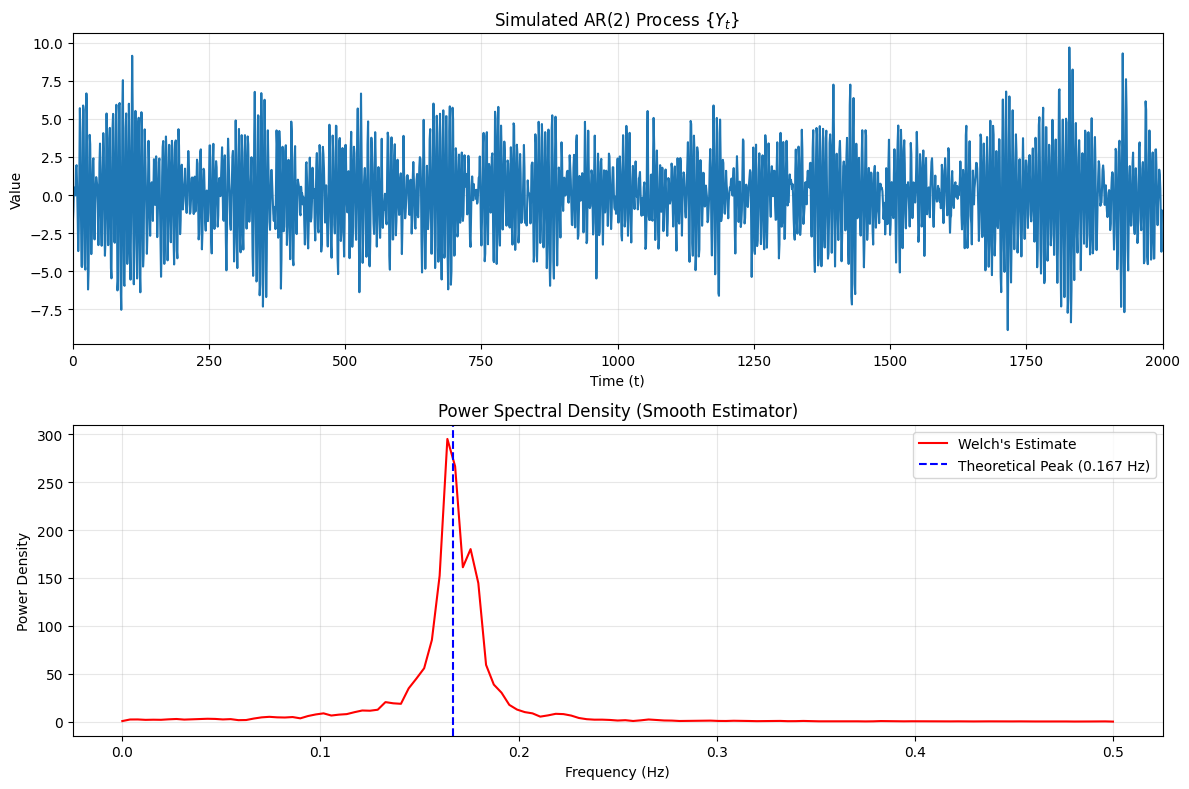

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch

# --- 1. Define Parameters ---
n_samples = 2000
r = 1.05
theta = 2 * np.pi / 6  # 2pi/6 = pi/3

# --- 2. Calculate AR Coefficients ---
# Based on the derivation:
# phi_1 = 1/r1 + 1/r2 = 2*cos(theta)/r
# phi_2 = -1/(r1*r2) = -1/r^2
phi_1 = (2 * np.cos(theta)) / r
phi_2 = -1 / (r**2)

print(f"Calculated Parameters:")
print(f"phi_1 = {phi_1:.4f}")
print(f"phi_2 = {phi_2:.4f}")

# --- 3. Simulate the Process ---
# We generate a bit more than n_samples to discard the transient "burn-in" phase
burn_in = 100
total_n = n_samples + burn_in

np.random.seed(42)  # Set seed for reproducibility
epsilon = np.random.normal(0, 1, total_n)  # White noise (variance 1)
Y = np.zeros(total_n)

# AR(2) Recursion: Y_t = phi_1*Y_{t-1} + phi_2*Y_{t-2} + epsilon_t
for t in range(2, total_n):
    Y[t] = phi_1 * Y[t-1] + phi_2 * Y[t-2] + epsilon[t]

# Discard burn-in samples
Y = Y[burn_in:]

# --- 4. Compute Power Spectrum (Smooth Estimator) ---
# We use Welch's method for a smooth estimate of the PSD
# fs=1 corresponds to the 1 Hz assumption
frequencies, power_spectrum = welch(Y, fs=1.0, nperseg=256)

# Theoretical Peak Location (for comparison)
theoretical_peak = theta / (2 * np.pi)

# --- 5. Plotting (Figure 2) ---
plt.figure(figsize=(12, 8))

# Subplot 1: Time Series Signal
plt.subplot(2, 1, 1)
plt.plot(Y)
plt.title(r'Simulated AR(2) Process $\{Y_t\}$')
plt.xlabel('Time (t)')
plt.ylabel('Value')
plt.xlim(0, n_samples)
plt.grid(True, alpha=0.3)

# Subplot 2: Periodogram (Smooth Estimator)
plt.subplot(2, 1, 2)
plt.plot(frequencies, power_spectrum, color='red', label="Welch's Estimate")
plt.axvline(x=theoretical_peak, color='blue', linestyle='--', label=f'Theoretical Peak ({theoretical_peak:.3f} Hz)')
plt.title(f'Power Spectral Density (Smooth Estimator)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Density')
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

## Question 4

In [3]:
signal_question_4 = np.array([-0.4660063139418452, 0.15203881196316202, 0.15819979628299907, 0.11085881533376842, 0.3702551247873387, -0.14764939761668475, 0.0005242759871536551, 0.02359456400585025, 0.1596483710856063, -0.323761952319536, -0.1475686421106783, -0.28142045506984575, -0.814422646968135, -0.16391894343863994, 0.23146644702935346, -0.29047335918346834, 0.06401571071714088, 0.24103338271568847, -0.16018841576610637, -0.20228284480286607, -0.21744836626816816, -0.2070277709613954, 0.8640548582335627, 0.3469532848247603, -0.16319241626905354, -0.015561809939087123, -0.7927845042595223, -0.5898984115750532, -0.2939025080841799, 0.2912999336934706, 0.49592358486052546, 0.02746759984182684, 0.07927812951132095, -0.41453289673010874, -1.037027302591971, -0.2729078256384515, -0.07067873207917819, -0.12004978967279764, 0.5055075840060094, 0.7214288056485215, -0.04984298866407566, 0.17843881471342735, -0.4537829723639949, -0.012521870053272766, -0.4276141859259953, -0.12426225999119242, 0.052078528251078504, 0.7857068869564137, 0.16717809974951575, 0.45103258572617144, 0.33528288458949174, 0.19895448863770965, -0.036417631045677634, -0.3988194722827184, -0.4340099664623037, -0.14305661611301151, -0.30362901432973394, -0.07694004793755067, 0.03630646986306907, 0.17704956367009028, 0.684917045447215, 0.7067218491510265, 0.0016991965871815395, 0.31562043880000107, -0.1773684245539836, -0.7567222354516769, -1.1422691899484443, -0.2889393611903869, -0.40430219753905117, -0.25547108240996985, -0.2823919317754031, 0.43894864660803384, 0.41590871434604115, 1.0265353506306854, 0.28841398395011625, 0.43782422953589745, -0.15712968928231133, -0.1697706923058148, -0.577984662586281, -0.8608626129064594, -0.7159334452154282, -0.9591067176529575, 0.04554757597540904, -0.19162973637128952, -0.4169860241543484, 0.14113037310175153, 0.2749158539367377, 0.5742825028494879, 0.41301937353882195, 0.5558608488110851, 0.6573533640511958, 0.21733418284552958, 0.30461502635315885, 0.3530746556010418, 0.02214883695455222, -0.5782903833127351, -1.15100252996948, -0.6827782112070878, -0.8335327889802311, -1.2086003497068785, -1.2383476467605572, -0.3614510886149789, -0.7207941364923621, -0.04379646470415885, 0.3703221904010983, 0.35679344447146355, 0.7173171911374024, 0.4411457454344495, 1.0137048040019572, 0.2986321735606018, 0.19587654866037496, 0.1164797172342309, 0.3537810342156763, 0.1157593745218574, -0.4769545822574158, -0.4079796800123001, -0.49201191756810225, -0.4248412365167748, -0.5137220703452653, -0.7855375546261288, -0.8886894320907628, -0.7927658630785384, -0.6378885175636876, -0.6696329588897441, 0.199357125548707, -0.3467554508307863, 0.4834682338042399, 0.3216211585412166, 0.69241469214574, 0.2577677376876165, 1.438242693619058, 0.6295591808928178, 0.35835795321041886, 0.3962566262042231, 0.7069367665411329, 0.402946334287979, 0.3451234451305736, -0.19958429285700224, -0.4968138412191052, -0.23825609264764222, -0.27808599116373356, -0.5901890015627114, -1.031870912795559, -0.9158240158844887, -1.1043785983789582, -1.098690190930629, -0.45338638291539013, -0.6043596167340723, -0.4797958174476912, -0.5866691433765708, -0.17626611974430384, -0.30171458066276213, 0.4110974894652043, 0.8220947227160529, 0.19245488139640954, 0.3268251261094955, 0.7982588825879199, 0.9058552092790844, 0.43353946938469207, 0.6313334511283897, 0.5968715619250549, 0.7018719578186661, 0.2326119502462871, 0.08805775692274076, -0.0002487613001644906, 0.2097675942648651, -0.2888926130102724, -0.3830706601213178, -0.3702359542228245, -0.6926312934211101, -0.6827357187311932, -0.5403784391262093, -0.39890603265444924, -1.0049666768022862, -0.5895066562010087, -0.5453133391387681, -1.0376608770100122, -0.6376861562686724, -0.8000788099739109, -0.6235957812679973, -0.7584310756378901, -0.0005047218097599115, -0.7506754202669594, -0.8728306218958831, -0.20607655964640445, 0.4380602042893484, 0.0631911783555055, 0.41606459913681026, 0.7524507327127425, 0.6646096989698058, 1.0812860964340687, 0.6362348357322272, 1.420302899598887, 1.2290379835271381, 0.8398817947258506, 1.1955091157665874, 0.9218819215026252, 0.7651416116341658, 0.3260753549104959, 0.24980387265941828, 0.8619720427948036, 0.5413212345445148, 0.75344013681627, 0.9437504679684692, 0.8229782503931544, -0.06868561576794285, -0.24083092318851143, -0.16348547407941122, -0.21983960094990618, -0.2234985844350315, -0.5442841109093617, -1.1090254317828747, -1.0692262988205712, -1.0311444681448683, -1.0463991933629506, -0.7547576218802843, -0.6669248503172255, -0.43062521202811277, -1.3100343650370014, -0.6374674572495302, -1.0016865712262657, -1.0838122383999353, -1.3845665342416873, -0.796076192585283, -0.4353868401913798, -0.15151625802405727, -0.37246733205292426, -0.6455520355548219, -0.06764525286526969, 0.19848461929128383, 0.19025282737085455, 0.2480703002568882, -0.010708803979980586, 0.6535323216815243, 0.4051681553281415, 0.7775349444422903, 0.25985874296907807, 1.2813471913781482, 0.8401300324561948, 0.9429152190139902, 1.3168148961692447, 1.5866378423391028, 1.3486653665713024, 1.482541562403446, 0.8293698877139742, 1.0724857822179874, 0.6802826868371723, 0.8188192070612259, 0.962663306971637, 0.36845199411321594, 0.756755097051322, 0.752210791611863, 0.38986562865703017, 0.6574502835380328, 0.007504179250046705, 0.1838674987125118, 0.029790629213519423, -0.6271382754488101, 0.1171979146305277, -0.11141901947367983, -0.8809114722316083, -0.3616683035901601, -0.5478619457543988, -0.974856927069109, -0.6904788943368387, -1.2715536403288148, -0.9239539770622426, -0.9837108330244109, -0.9438605564517939, -0.7994752087117605, -1.4806761102609487, -0.7124480239368176, -1.385256783850306, -1.6322653603733204, -1.1694866014313612, -0.8152959142331946, -0.9497534695360672, -0.8422631221042437, -0.760656738828291, -0.710178220651561, -0.7468855877901186, -1.1010569719402692, -0.9691840106908836, -0.8005541473913875, -0.650825324077705, 0.14635686935998776, 0.15788100715367176, -0.3798457776530374, -0.23625825222161165, 0.13011618016938242, -0.2636005896564838, 0.1478097404576034, 0.5670846156655377, 0.7809662234166799, 0.9179799942154216, 0.6309588219822551, 1.0121742982106583, 0.8384696544196332, 0.30404812968774386, 1.2209632061913396, 1.4107656779468507, 1.2862768626399457, 0.9089089051273382, 1.548361719817323, 1.4171495501443192, 1.5271254543803687, 1.3604848080238146, 1.2534300478722762, 1.0855891989250401, 0.9574506958877597, 1.5538078845173526, 1.1554876934966856, 1.7791269454507992, 1.2452309566065443, 1.1654691545641087, 1.00137236056542, 1.2539448025714335, 1.0461729576933236, 0.7107564348788391, 0.2074052026025377, 1.2619642946642926, 0.05124365506674722, 1.0283035970224936, 0.13828669448890063, -0.005970151312822414, 0.06925722627412603, -0.15536162122513458, 0.18867582952363315, 0.04137175866181909, -0.008025046419795484, -0.330142293967175, -0.7685178002237567, 0.19043959941996214, -0.010447336084648706, -0.1649352193217764, -0.1388035297136283, -0.17335021488646285, -0.6925084273043791, -0.5912499151363558, -1.1055705659936572, -1.072079508309824, -0.9395868460840675, -1.5095678057755406, -0.7566238331846367, -1.208502531077844, -1.0704611610317245, -1.3077476084331014, -0.8549471873342813, -0.8795300501220145, -1.196969159103322, -1.4927118010948082, -1.4069244291993221, -1.4537212925141496, -1.3322471276939034, -1.0920511140255131, -1.151591828102376, -1.1219983282083552, -0.7821230203797678, -1.0289070146454449, -1.4103544336562266, -0.7835691817224246, -0.7621470106677987, -1.0652123249566279, -0.83013046349589, -0.7144578467098963, -1.0255430591579917, -0.42378913844827326, -0.6899087030165446, -0.39843131554970634, -0.7567576170967254, -0.3131179994947043, -0.2000749766669344, -0.9339515969891947, -0.277993410661576, -0.383323259682049, -0.30780113331052045, 0.010923561345844685, -0.24510816396876633, 0.43179346248769535, 0.2119962699211757, 0.4651875082008208, 0.2481356119920591, 0.9008957705766503, 0.36322702844350824, 0.5285464284994229, 0.9167204413602491, 0.9717812608318734, 1.099425769063865, 0.7406777523407548, 0.7556536887808135, 0.7870407130131581, 1.0677102064919106, 0.9275690671048273, 1.3732114146901442, 0.8121796466089287, 1.5968810294853517, 1.0807081330780544, 1.3698375590058423, 1.304902035518833, 1.1226253585946415, 1.111473219095495, 1.33369158190424, 1.6271481873777962, 1.1406028311853538, 1.1588531095972976, 1.3188721279396451, 1.6270690814948108, 1.0433910920236524, 1.5251579749043451, 1.5674838278447156, 1.305368020988774, 1.3851796916633325, 1.5591407688414025, 1.5077084666093188, 0.7999421068721349, 1.754012764455547, 0.717650801059138, 1.2961552331251736, 0.8102996539812473, 1.423210816637274, 0.9566078960798786, 1.1161372823386315, 0.6176724853387139, 0.8377679170656247, 0.3999684929692455, 0.41119409806961266, 0.16841115670984902, 0.4369376678124939, 0.38506992416872576, 0.474851793807514, 0.3469665360076064, -0.15772426196448852, -0.12700720454006914, 0.5999338698010941, -0.2233463873044972, -0.10186003363153827, 0.09678007002596935, 0.0369528137750903, -0.2823864096346691, -0.48999579968489204, -0.33217751849115024, -0.37350905270596035, -0.26831637508655626, -0.5448147690397749, -0.5046927601621864, -0.9008781308699394, -0.5905559342844885, -0.9638928959103766, -0.969429853457635, -0.45851384176412846, -0.66404176367885, -1.2576491041713287, -0.8873498435442905, -1.5132644451310542, -1.141057159161021, -1.1368736117165492, -0.8100335517828432, -1.6727560496353884, -1.0651896046763847, -0.9166506147701265, -1.4409246606174955, -1.197252048548961, -1.305965192035501, -1.8173654862686102, -1.4255771191933475, -2.022924708095652, -1.5118067555702879, -1.5458643024431729, -1.144840472960721, -1.7785426723045792, -1.2381674304491215, -1.7722875278844803, -1.3739253891509422, -1.248683631547167, -1.0058347625464505, -1.5424237039670001, -0.7465994414337759, -1.6138954693819558, -1.3280410386090815, -1.041331162754691, -1.3907571173314277, -0.8300310361867049, -1.6059225793830127, -1.1248409086672582, -1.4414775724005962, -0.8037822978580094, -1.5369113084447996, -1.3195596822310407, -1.0960857847210144, -0.6896540045968196, -1.0289404055511837, -1.4054153104550844, -1.2226390335821797, -0.773876787189083, -1.0911791193399498, -1.106256666206422, -0.7978104007489821, -0.8552974336225769, -0.25568191089253933, -0.8670527629164613, -0.47829188826957214, -0.8490896605848299, -0.6360519852895928, -0.7312508847872561, 0.1669348871142013, -0.011237586508915709, 0.2083595416123682, -0.3214807641949934, -0.46284600179405544, -0.28676433593359046, 0.4559100325726171, 0.015418361263809632, 0.14543755622356136, 0.45479863077907795, -0.29587518120595346, 0.4444776750608242, 0.6929572368114519, 0.3699175922027594, 0.36092846268209966, 0.28513734866844104, 0.9390406696994521, 0.16654402576160576, 0.9976402961427113, 0.7199356154227541, 0.5748699775686679, 0.1893566414076357, 0.8747627447436267, 0.8368896938094628, 0.9960820334269154, 1.0517822657342688, 0.38085970236238187, 0.6674081023833143, 1.3208217906909527, 1.0385741390974361, 0.9701491051586687, 1.3235783894515052, 0.9801202874347296, 0.7452057395502689, 1.5563912228697667, 0.6389259524463818, 1.6310161254131756, 1.079965755255517, 0.643006574860935, 1.202914792664712, 1.4814953365163277, 1.3314951556726677, 0.8301862567125292, 1.5721317815010865, 1.4367881014876442, 1.3355734382690168, 1.4143137433889037, 1.486564686448278, 1.4139801415139504, 1.62136016071387, 1.3877104937931417, 2.098163323463967, 1.6253319579649539, 1.175152484796546, 1.2191923427642086, 1.4798752463139793, 1.6477838314616307, 1.75791877649767, 2.0045780307376533, 1.0672169196544938, 1.75346684082441, 1.3009054791219656, 1.8806800732075035, 1.9194145093875847, 2.003287518323991, 1.373935019331056, 1.6915026208417372, 1.4460999289021528, 1.2735997595511293, 0.5478629416636053, 1.4646537492186988, 1.7481165756530568, 1.5440373377099739, 1.324163603155089, 1.2482222657336024, 1.4840305438917973, 0.9531006032706422, 1.0187524732359619, 1.3368515990142495, 0.8902894364549336, 1.1424285202319946, 1.0731749126184318, 0.7527996494692635, 0.8506087683076553, 1.3904939776292402, 1.2701684905680708, 0.80226778165595, 1.5518648777766764, 1.234445325482229, 0.7801010093976672, 0.35267094779436003, 0.4880606197136544, 0.523474681464075, 0.48805988987326065, 0.2981735167454466, 0.22092693264621638, 0.2711417712793317, 0.09929467317317348, 0.7363914643666308, 0.46404375768720096, 0.023246508926835663, 0.9934241969510517, -0.45989791333646834, 0.21587667045980488, 0.4949883130068071, 0.364880884804514, 0.6052521484558195, -0.4764486761525076, 0.075063739684775, -0.01645389573721104, 0.7056159691710804, -0.11233919414254893, -0.5200927751026967, -0.2034910608732134, -0.08071015456980375, -0.2839892110648735, -0.32318720650910926, -0.5219462677253612, -0.172198488968824, -0.519329763704216, -0.47886852520489753, -0.17432199272848914, -0.6662256486184946, -0.7078524193624935, -0.28143837465041815, -0.45294574923691544, -0.4319270925543677, -0.7165881948202811, -0.5106717218966399, -1.1548314840038671, -0.5943979927312087, -1.2273008687106999, -0.5950165345332799, -0.41443053644155137, -0.6886537216674424, -1.53008154695848, -0.616889424115391, -1.4274562448308465, -1.3178593939211005, -1.2665891329694072, -1.1703070410150183, -1.1592921965385417, -1.574438161468228, -1.1097765116582519, -1.0668048037695401, -1.22090878045255, -1.2250325442406225, -1.3374087222120556, -1.3340004064690032, -1.598623617171199, -1.1363287918569953, -0.9841593411041586, -1.5154901984681453, -1.291505821078321, -1.4065031051664685, -1.739692410686273, -1.5432984622928474, -1.384652499239847, -1.6359291282674888, -1.702356427394752, -1.5345629394175928, -1.5974461334585628, -1.6779171215257251, -1.6830512889701803, -1.6912731734031001, -1.5773143308776623, -1.9042656454082636, -1.4129852868544943, -1.5635531976750332, -1.3443564205446332, -1.6601592148678006, -1.7209023063948785, -1.5404727809633945, -1.5419087749090912, -1.86923853384898, -1.4695816307341807, -1.2865825044428023, -2.0007197171965716, -1.6530634015258103, -1.224884724424506, -1.190345791297221, -1.9218669207661037, -1.795767355407873, -1.6346157831162345, -1.3497426283492202, -1.5762433053419287, -1.4023268930042863, -1.9525889552932423, -1.4605346302942233, -1.3646020934600938, -2.3829940530137326, -0.9599753843391733, -1.4771274428964485, -1.3592594945242513, -1.2669476497462226, -1.6691924247144807, -0.9339903955365731, -1.5124145425303286, -1.0483343909136247, -1.3512236423780977, -0.8028000606570879, -1.579097944961548, -0.5032038085505209, -1.342206445485792, -1.3905963804663413, -1.4621432809420734, -1.2698036043987808, -1.2919559805187355, -1.0588804254345012, -1.1002617374638397, -1.5275869247563316, -1.0559213607944455, -0.9546658709305641, -0.9083564718523789, -1.6246160458729788, -0.6291861511128153, -0.8146739554512861, -1.2941558681323435, -0.5442854153027761, -0.8929408047951067, -1.5727283928457094, -0.5300586259071687, -0.4527068251187665, -0.938890115408917, -0.7710718978975516, -0.847784248884268, -0.6989602356203919, -0.5148971683791512, -0.7279604488428327, -0.35294256202788815, -0.44052515150117805, -0.6110016130164775, -0.533636771981807, -0.7767712544335642, -1.0318829857757703, -0.5664667825331099, -0.18480446623989405, -0.24742707182253565, -0.6020783724953769, -0.41830835895310536, -0.6945458555575421, -0.03641095076673617, 0.2560578556957207, 0.16513918246193343, -0.15281445617195535, -0.6502943905394367, -0.835917563843382, 0.05530171103464046, 0.5112457841145251, -0.1363283117546804, 0.31518361807346523, 0.3103553992217604, 0.280400015108101, -0.07119131218423948, 0.13260178159761407, 0.3548719770424779, 0.44430563224219694, 0.480485605882368, 0.24333976377982625, 0.2731733141943514, -0.24508120236560807, 0.9268851726756822, 0.5309906048423874, 0.05881039513336045, -0.16520027214123545, 0.5452038309162626, 0.6360525502071523, 0.6910149100673573, 0.5187841827585087, 0.14192407704732068, 0.5662355516826265, 0.05803173593523092, 0.5129926475988202, 0.7657284995047096, 1.241079362370118, 0.8325282507283149, 1.0988143302491369, 0.5561706172963832, 0.9394076221990686, 1.2217661470409813, 0.8195125326481665, 0.9227832428081937, 1.275641834016937, 0.7426818434415311, 0.3843494140695561, 0.391746341043178, 1.224002650032809, 1.2422916875741872, 1.1173738238319162, 0.7204810803423267, 0.9518836587091737, 0.9798198461339932, 1.2577463839964522, 0.6686778121898177, 0.9109255059193968, 0.6077996224176967, 0.8866475158541007, 1.2648063182774048, 0.9566541777769952, 0.8771252429460519, 0.7715522586559134, 1.2487036636352198, 1.941402630911107, 2.0548848622245255, 1.7506031875677812, 1.4149053272796281, 1.528921340901402, 1.8218752134356364, 1.7803114521411303, 1.4514917769531241, 1.7319161123990703, 1.9116896295320374, 0.8266671008647766, 1.1717517347975797, 1.0375845957721217, 1.4396833140936507, 1.6711302843914901, 1.8967966432309606, 1.8430120530079077, 2.3843649430564744, 1.976749896637077, 1.3731732597775144, 0.9402390797020183, 1.6733292075060642, 1.748609123011439, 1.7019996670537365, 1.261622313131673, 1.2037457026782707, 1.6232466675249977, 1.3903842728416056, 1.828337701277356, 1.4319567787902772, 1.107026692643918, 1.9521210366987303, 1.2773326973616448, 1.5418247596800903, 1.7413771480488986, 1.7328792369849857, 1.6216113629898552, 1.5550696609220973, 1.691572176068832, 1.6299970708354143, 2.316570613491435, 1.9043630839899603, 1.7416957834100517, 1.7141687463242234, 2.291907867275498, 2.179768723715701, 1.280857651762138, 1.8209998807956114, 1.9508326111304874, 1.6026208867321994, 1.3276514895140723, 1.6326437100290285, 1.6151920344586677, 1.7985975903460218, 1.8861260128927446, 1.8141582295215406, 1.2599089834637387, 1.6997262694858497, 1.2760079112976446, 1.7275319720149418, 1.4599395610528805, 1.5442691703624276, 1.8426677648630991, 1.2644599904155993, 1.2738780455873775, 1.8918753789377498, 1.9230533970710724, 1.3781897253615902, 0.8090603170747522, 1.0686355723850753, 1.6946165650835714, 1.6857280420095382, 1.4755952473354736, 1.6979271969164635, 1.1672023827024371, 1.8182503981803089, 1.3956805521638906, 1.116469123973141, 1.0164199281639128, 1.0428828166097186, 1.7790437829859413, 1.6247855686424346, 1.2373048324852463, 1.6017996608385932, 1.2096267955844995, 1.6599312338381864, 0.788664240619621, 1.0168709512353904, 1.3973909541518692, 1.8839450361510792, 1.9771206270683883, 1.4420596928354352, 1.0964704308332025, 0.9274711433359528, 1.5672060648753392, 1.4104242316384907, 1.8554428206851519, 1.4848942419960145, 1.6650963483330659, 1.2138709746308272, 0.9394123727323644, 1.0107354878442283, 1.586644355505942, 1.0736309113990612, 0.7213236946009788, 1.0935283088783072, 0.7877521463014779, 1.716640793236968, 1.3151491547916625, 1.2356522674331172, 0.7897786933057529, 0.7337912367517667, 0.507655730099101, 0.7625394625633959, 0.9497816957002092, 0.901706716518895, 1.2175297458770136, 1.2228846382552967, 1.3765681095470466, 1.4997877736613479, 1.4690689640137338, 1.234624158962198, 1.1393907496964393, 0.9751221197845257, 0.6683860270708666, 0.6914882296402893, 0.9627579724708493, 1.1189628094353308, 1.0363671181881884, 0.5833095167445211, 0.49578430349290936, 1.0423603189136474, 0.22502660094318366, 1.1965062027009261, 0.5104483647211122, 0.8167409720256605, 0.29693497407484054, 0.9706521262326766, 0.7002913501437732, 0.6013458912057907, 0.30406466756873374, 0.7208160354611866, 0.056327771447497954, 0.38086648839762177, 0.3876110698061761, 0.26672307628543435, 0.5830443949550885, 0.35013592476088107, -0.2768416991269139, 0.10989871011672614, 0.17783552085743082, -0.20337144880029373, 0.23843340465164992, 0.5048176680995761, 0.1974076322940042, 0.036477091179891674, -0.29650275242279045, 0.5507832367089345, -0.3194496554934221, 0.6149705284105074, 0.12485561027409658, -0.26941884519776405, -0.3400829479704962, -0.2965574916717706, 0.06311179144660722, 0.24146351784737424, -0.19036574284284688, 0.27776755417590104, -0.49238276812586457, -0.2309780671500507, 0.0037745158670431517, 0.03685525627265661, -0.6667662281442096, -0.38609880283051035, -0.5400068005055209, -0.13364754950577282, -0.5390699719103711, -0.2784219688872844, 0.044485119137954526, -0.12965267959422938, -0.3615175370916933, -0.7509980772680074, -0.8616677398171894, 0.18810786245858985, -0.4172602123071023, -0.38889531419727913, -0.28817731516327516, -0.4288679033980523, -0.6398306438476196, -0.0634477670739872, -0.9127645089221736, -0.19105225025033346, -0.3783211567904994, -0.7047080308403803, -0.285496666670297, -0.11695749461620297, -0.5660562565514311, -0.4688498803695784, -0.50234700789733, -0.3585541510448517, -0.5145961857609047, -0.08210218227577193, -0.46984082721491716, -0.7926780048817496, -0.617216154576279, -0.2620231748045413, -0.8831575623602765, -0.7323710898578302, -0.7875114483533401, -0.5164240208799603, -0.4589767109560348, -0.9305734241357017, -0.6089600166228238, -0.7316122868819881, -1.3788627432788148, -0.9723961299388318, -0.7585900100243188, -1.0526849533730906, -0.2721589379980237, -0.5547458510817467, -1.2248653492067123, -1.3727990087791884, -1.0081816339319507, -0.5775211077928537, -0.9885769512006815, -0.9771678336432676, -1.0372460429263524, -1.4474270783937697, -1.0978143065935542, -1.2737898882086789, -0.9727775567954543, -1.1247843498138759, -1.054688007085974, -0.9932282020249239, -0.6917790764093917, -1.0637200514290588, -1.1331506608686452, -0.910391440267527, -1.0970969412894036, -1.407537928707553, -1.5518620020611964, -0.7317309185489705, -1.3472972243877313, -0.8977095550722032, -1.910529313832026, -1.5947214746202472, -0.9915547563192126, -1.1154840952871965, -0.7519305258106748, -1.4763898604699124, -1.5915245056680414, -1.3447462495426838, -1.4048505465340804, -1.3922957277585852, -1.6287085343543923, -0.86744344825055, -1.6563425841806405, -1.7230969174625446, -1.5690468078533426, -1.3603938118321424, -0.7833685841113452, -1.1124337358126783, -1.0910845348623883, -1.3234286420235906, -1.5345295873690314, -1.8427310882116548, -1.3386055273385262, -1.2352157602234073, -1.367081512377222, -1.5203784844186146, -0.8827385144721022, -1.222018996274397, -1.7965600241338398, -2.275403852857075, -1.2501755546920124, -2.103891169112678, -1.312869181440485, -1.5909700172493548, -1.95220143038991, -1.694181722720262, -2.4433881776840343, -1.3057467685349664, -1.7387381692354837, -1.4494956837077366, -1.8684017488774627, -1.536077641643414, -1.1717672727330453, -1.3859116317271138, -1.6748136740068007, -1.8550179974450443, -1.3953164744690632, -2.0022747912954078, -1.7315763147232721, -2.0781773408866804, -1.5830076717510053, -2.086284238807918, -1.4795012686258282, -2.4000053233595535, -1.576225651290525, -1.4421081424230062, -1.8844366962464072, -1.6357200632029714, -1.7954172295631652, -1.8323444125708896, -1.9565309617244653, -2.1033230014555864, -1.826366620602831, -1.7619796518751334, -1.820227996999427, -1.2301114683422238, -2.5308673875147423, -1.9545625845705146, -1.9513166874982688, -2.009476177553836, -1.4199967869891694, -1.7589953721195002, -1.5884068841354402, -1.3250730905257644, -1.5541476528906546, -1.559954563187296, -1.8417504148987565, -1.8408920137031144, -1.3404612703578838, -1.5774629415133223, -1.9722777074698103, -1.5866985270643081, -2.3673069873176376, -1.9040370334776626, -1.6228632712185365, -1.0970281561624184, -1.8382299340119501, -1.6918869383356987, -1.7800659788008444, -1.990113836650936, -1.8853529705376615, -2.5492462603601487, -1.9822838994120682, -1.5362386457661548, -1.6052459565870303, -2.3112073119636416, -1.0800560372210888, -1.4474046301715435, -1.3408465681064945, -1.8278192800488184, -1.8328647986909952, -1.0184832138976214, -1.5843596935463482, -2.446027653335679, -1.3686890779956198, -1.605819165177243, -1.6377826105646573, -1.4490089341447392, -1.580905976333403, -2.014494290372021, -1.9205427240680506, -1.718062266462636, -1.926543961825639, -1.7236305590777397, -1.5414443585162536, -1.9214381144326478, -1.5837106690346605, -1.8852228270502773, -1.8281586686789104, -1.6430101122121146, -2.3038294590800494, -2.1295183077700313, -1.855345835578229, -1.721921284198168, -2.1045620771224884, -1.7882215566897628, -1.7388506525979548, -1.5651330420213738, -1.8546259327039267, -1.1173812622854322, -1.3116362886607527, -1.2668864827114357, -1.9304894375716593, -1.7568452946074031, -1.5872724462188452, -1.0598561314824895, -1.5180062440019326, -1.4036872183541222, -1.5953532376671677, -1.636646221219412, -2.053514949065643, -2.0958762627539986, -1.3789595507660175, -1.7919788554630243, -1.1229847770938186, -1.3881669793916616, -1.5576935471362847, -1.3668262079815154, -1.937634651097209, -1.801998153595189, -1.7051909946027686, -1.1810901298832488, -1.4211327704208654, -1.4352853337837403, -1.1860914530137183, -1.1033604620321866, -0.9242057582670944, -0.7332356987367752, -1.1540702603363073, -1.255113774026584, -1.541831181585981, -1.092727719332377, -1.2930136015811413, -1.1194323146833347, -1.0604943603342416, -0.7667583897558767, -0.8856407776422174, -1.080626993628674, -1.5485506638690174, -0.95298455677345, -1.5002839524197877, -1.4821440172439935, -1.2430904306635484, -1.5901553543864948, -0.9200346210506136, -1.2891134172557193, -1.7495525030443995, -1.815518677982897, -1.2466222135977638, -0.97545176345552, -1.1217746607615124, -0.8707977738612012, -1.454709201952186, -1.0569974294168571, -1.1726585663115685, -0.9551304785373159, -1.3740043369965704, -1.4240424202575788, -1.4998511476466816, -0.6826977401786931, -1.18040275466736, -1.051496108877122, -0.8381384190717154, -0.9273105692744175, -1.03655354161633, -0.8726311115583631, -1.0762821051937759, -0.9899041684961715, -0.8903058434372794, -1.076069334528124, -0.6172025785865976, -1.4161756948960345, -1.1981252776760725, -1.1564657094405968, -1.157923641084723, -0.5727549573308397, -0.5694830540179784, -0.6180959385733218, -0.7563007805211955, -0.8457951101247356, -0.7954419013718758, -0.5828335364191191, -0.597554879472503, -0.9054029501700224, -0.46124545116482385, -0.6149037325067629, -0.5628469576435586, -0.8318419564452932, -0.9564605854313482, -0.5435810820077388, -0.6366634396256508, -0.802272417012409, -0.5806718930425411, -0.7658229521210557, -0.33615511557330463, -1.1722858580733302, -0.7305056699260305, -0.6734296850487308, -0.5262234441329441, 0.02525094043021714, -0.2539498941659985, -0.7558842009361042, -0.7983546831591991, -0.8941541779954069, -1.0717101398791458, -0.9798424674683449, -0.8007387482908684, -0.6630640545024041, -0.5632362217799538, -0.7852909022299011, -0.5423143684480117, -1.0030314500225284, -0.31881273314629155, -0.5531670910921446, -0.6136100994109627, -0.04735488870661991, -0.45997918668833193, 0.1538444517017022, -0.7064845654535346, -0.04546766630472121, -0.20135795820257837, -0.16842425342872916, -0.39599409218353404, -0.2618097580514204, 0.0844735275898173, -0.6832893335077577, 0.34983197241071295, 0.19620514956019697, 0.0038875981584786112, 0.0664385321377457, -0.6379240848479157, -0.1881000514116695, -0.5252822790924446, 0.36452002961606456, -0.1465506482655701, 0.030839725579417276, -0.65627535058737, -0.29004331324465593, 0.31345264852857957, 0.3121627134137853, -0.12270393234260064, -0.5233569103910563, 0.08326590655492472, 0.1136244560325603, -0.11523728485922125, -0.04307356638533623, 0.3760591751265653, -0.06618490661762333, -0.29312757774930276, 0.20492674160538152, -0.31778574636569146, 0.048727260997343654, -0.3502167590332137, 0.5871627544146303, 0.07053561971691126, 0.6268579582666117, 0.5476869191450443, 0.4768596094322882, 0.2830397182629424, 0.31912076231455017, 0.03749320999039714, -0.33332697292992364, 0.27272694751845505, 0.2743734363532056, -0.47796654700298424, 0.3153548499783037, 0.2598280001593942, 0.4437242956962696, 0.6496713372675953, 0.22578983530209498, 0.08400744106159475, 0.035156793332478065, 0.8252866326121462, 0.04116006777572062, 0.042229045891794104, 0.7893501659920867, 0.7412922787047876, 0.8929539415203434, 0.6327051220400786, 0.555811169170698, -0.11280570043800275, -0.05327608826478947, -0.10890586866599039, 0.460417752548997, 0.49510601262513004, 0.4362864214874658, 0.5406953163130352, 0.7817554799593089, 0.36505690077343383, 0.5206994375773696, 1.0312549573374077, 0.1792014235097922, 0.4222433066084079, -0.03699322299544111, 0.44009586195185546, 0.41307637765622396, 0.5357241016120418, 0.3056758547666174, 0.5391890370047143, 0.4339167098113921, 0.9406092139198181, 0.8668548869807324, 1.0557620161925496, 0.5169113676789563, 0.534781396101292, 0.426464794246648, 0.4273297855137041, 0.5052324627068805, 0.8316454816890737, 0.37873048147615135, 0.8538884110884827, 0.47156518208919856, 0.612366095406875, 0.6706121581660174, 0.5722960589989717, 0.13920433923112752, 1.1879309664467903, 0.832842062522188, 0.9612105749413924, 1.0050137794383764, 1.114049149848464, 0.8722205408561167, 0.47626125092999616, 0.3293962136499291, 1.3076135076022668, 1.6891920703840957, 0.5528899497860841, 1.0803006915627447, 0.352086693052577, 0.26329282246194263, 0.8229216002526537, 0.7112272511001722, 0.6753779272272379, 0.6928461289981237, 0.3066813912689068, 1.0876106208881642, 0.7766769164488457, 0.7684614342902825, 0.9278048360261609, 1.0785356057355393, 0.6868389971314698, 0.6017175436004969, 0.9458086602454863, 0.7423525075259524, 0.8247279884440286, 0.9270003631973992, 1.3861275455965552, 0.48598961332859486, 0.17676527882424553, 1.558186314074098, 0.9790766331820737, 0.6655169556110954, 0.9186140462934088, 0.7801115878466176, 0.9091823352489686, 1.127604345310022, 1.0808201149032808, 1.053850815899233, 0.6962014096463143, 0.37982118238872953, 1.5021794624924156, 0.8425255468863042, 1.3544885573925818, 0.9756103315411091, 0.9857899926868264, 0.7312234190126303, 0.852609702524032, 0.6473344370024291, 1.1251894403952787, 1.6565782271794744, 1.2060299616304069, 1.5308135429746044, 0.9417182531764678, 1.130002463454731, 1.3852189395268761, 1.178736640529191, 0.6839971281202656, 1.1825784697919226, 1.239053237845757, 0.9938222716785572, 0.8465534649636339, 0.8567563301100927, 1.0864443662945522, 1.3984920644142824, 0.8465620790214834, 0.6151960739668249, 1.2236819056565098, 1.0497663962567603, 1.706599817844178, 0.7913568910154163, 0.8461366956702194, 1.0767449223929575, 0.9738506291103324, 0.8781508054327192, 0.9850027269524749, 1.0570468357024236, 0.7612803396481602, 0.8161736223107132, 1.6496416245053156, 1.2920200440235936, 1.936865005773817, 1.1195391909065304, 0.8291104800722557, 1.3860389756024767, 1.0860162581716766, 1.0986826657070128, 1.2937177024798314, 1.4700922573093615, 0.8327637117404367, 1.0292611301724022, 0.5672401176497187, 1.2323615694870682, 1.2836070655371778, 1.2147524408666344, 1.6351145398094171, 1.3108160212192375, 1.0992187861963947, 1.0598723031871136, 0.9788189472448796, 1.2156025576937226, 1.3123802776949416, 1.2366852413260156, 1.5840664759405563, 1.503675734824745, 1.1318596171135358, 1.8296221430258228, 1.4725173617084075, 1.3659794119456714, 1.4796605173758557, 1.3848893808304616, 0.8765259677731438, 1.4138936981052246, 1.0553114658505756, 0.9163354835693418, 0.9998880717604035, 1.335410810102578, 1.0956455768930065, 1.1505674736879286, 0.9947301404604721, 1.4212107322369345, 1.758419594611107, 1.1190052440542158, 1.5078832157146445, 1.3398926024582956, 0.847726233754877, 1.6169322368955301, 0.9568113994093432, 1.3452735190037561, 1.3418984397739426, 1.6899098424329437, 1.2079053253041854, 1.6835164203737438, 1.6183038031794021, 1.4810784405817088, 1.886703050646643, 1.1296136669911292, 2.0786826116618666, 0.8962952179531616, 1.238445408184166, 1.119992020431449, 1.6054449288824493, 1.253449007211463, 0.93032949032575, 1.2318615377048108, 1.2359103494014945, 1.1540930611130054, 1.5029811591171454, 1.757210946798878, 1.0116399955008848, 1.0122242607952974, 1.472823463704377, 1.5605632090917465, 1.5392651606960732, 1.233438741710077, 1.2320203870682844, 1.1719055362594832, 1.8981770643531113, 1.3228808781243093, 1.0877269982071402, 1.1810906723840155, 1.8048896269560675, 1.7567020346433209, 1.335764272678037, 1.466617956826846, 1.9613155873647972, 1.4273726634979487, 1.7831472481607946, 2.129208950090028, 1.3327024958362663, 1.297351049167836, 1.111339993292288, 1.1190121693105588, 1.4434114295433749, 1.7971637661263955, 1.5587777469541413, 1.4613105174119232, 1.3018885994714273, 1.6492853025577854, 1.2636682060872333, 0.9725061272503681, 1.6187009457132167, 1.0709746968724143, 1.1496288434223896, 1.1467824142626302, 1.0964798817240085, 1.520723335335954, 1.518093185417122, 1.047530357193036, 0.9525033092185613, 1.4616165765815268, 1.051554384870777, 1.4154949276237665, 1.9115449822498385, 1.593499399002506, 1.0829716135838896, 0.9331940634074647, 1.8538666292404886, 1.2095911848525103, 1.345808884514114, 1.672708317237615, 1.3318789843912375, 0.8988096578998592, 1.5662331887161567, 1.7450673482508638, 1.4345986601002507, 1.5170593511993367, 1.1574994406913934, 1.5346547285448255, 1.2022545370102433, 1.8481611978166117, 1.128703699599578, 1.3824163615263545, 0.914471758718922, 1.30570472328421, 1.47588769381351, 1.8925354335030462, 1.0029229998347244, 0.6628120252525006, 1.5125316098963963, 0.7781000005302683, 1.7788684732213917, 1.0666137180400737, 1.1271045066310463, 1.4267686501714352, 1.4417756466131066, 1.7601129145164536, 1.505830638160938, 1.015539581684261, 1.5376780971845763, 1.9088890962201575, 1.5246218842283699, 1.5688206086012513, 1.5821377559390386, 1.6275125210367993, 1.9778559566723768, 1.1725830702052158, 1.570284983384873, 1.3600736172604035, 1.5665086756585926, 1.5995019114617208, 1.4951772531059617, 1.7635740252829608, 1.0859325349404882, 1.5017119711554134, 0.8382463644891234, 1.4352416457061743, 1.466850768622143, 1.4072712625608044, 1.0607929840428743, 1.0610915718779146, 1.5270096092776755, 1.6979580576184767, 1.5844793986005017, 1.4168849001039008, 1.1929867803924363, 1.5744349437306546, 1.6176758469784822, 1.2953644792200056, 1.5287757908430628, 1.3709870094537135, 1.3176363567378704, 0.7782670684084566, 1.8551034365427674, 1.3750361561402231, 1.5535362844194331, 1.5188989362432541, 1.3978005615953244, 1.4344828860483878, 1.5302469667518872, 1.09048566981776, 1.2426890494212897, 1.2098382263176406, 1.6895734463485654, 1.4296258935878237, 1.0289700682875265, 1.2722077465118826, 1.6993758901757001, 1.5883509979952006, 1.5707510174059411, 1.2700352536306272, 1.389726134255621, 1.4024000774494216, 0.8717456864852493, 1.2426122690563, 0.672998654638021, 0.9778989100653224, 1.569649064839555, 0.8760266881268408, 1.4492420975616633, 1.33055674282029, 1.1365185496486903, 0.3768901439773137, 1.424414592484754, 1.1551877029081543, 1.3052028631924815, 0.7486191379788937, 1.4236498071661023, 0.9036259156125707, 1.4969824033547805, 1.299163902677232, 1.2700507669502947, 1.7599437359922276, 1.36646845433035, 0.7241719463383092, 1.4915272263847, 1.1749538620937772, 1.228262519354142, 1.0606115499678035, 1.274698120957048, 1.0855793768219393, 1.028741082231024, 1.2440744782569668, 1.8532980785761355, 1.4455897417673642, 0.373020302110718, 1.323034979314212, 1.3010342122346201, 0.9905931225960132, 1.4884097422511915, 1.0818930172172991, 1.1983029661277613, 0.8037714354455074, 1.3580127224634622, 0.7765671530464748, 1.1161720115525544, 1.218777789228004, 0.6951318886568081, 1.1465553855732742, 1.4340391575595965, 1.1822619911910988, 1.086171168268133, 0.4382454163442323, 1.4297018718656178, 1.561260385367492, 1.7208198356912419, 0.8034771045062684, 1.2716106055430227, 0.6443219184381168, 1.3672393153006328, 0.9601008820047416, 1.4671306470133438, 0.6712242944120993, 0.5838786835284318, 0.7567286855246533, 0.6315705865348685, 1.2646519894997312, 0.8938780966249429, 1.0984082874644268, 1.11293894402612, 0.8876509736136474, 0.9477513774848911, 1.0587879937849058, 0.6742232606567625, 1.3499826220683215, 0.8502963397844997, 1.2928201763671807, 0.9731870939463989, 0.590371085447535, 0.8538743204345145, 1.2907238704009092, 0.8231535017742126, 0.9089390297690123, 0.860043687905184, 1.2069892209184776, 1.3381609574277022, 1.1189084141537675, 0.577644717769243, 0.800676342511666, 0.8162860991220692, 0.7598789848847005, 1.2340925201616395, 1.3468803052868314, 1.433803556936316, 0.8508874267841225, 0.8088346435492949, 1.0536576334777874, 1.2727443942746017, 0.3959001169187869, 1.1157203403642466, 0.8558169899317408, 0.538214397557748, 0.888966130581682, 0.9986449194444044, 0.5188649546393376, 0.8540383209015447, 0.24945834620922114, 1.1431936534190068, 0.9845843498997339, 1.0486253714615166, 0.6631600468471937, 0.6932436566076985, 0.9794788993415056, 0.698754501437588, 1.1691608332899897, 1.1172163041222203, 0.5573693274508051, 0.9875256065872926, 0.6714711712276604, 0.794053020223139, 0.9820424417328808, 1.862742012214429, 0.8930106701283281, 0.7616034380726145, 1.280022324061687, 0.509535325642732, 0.8762527186919176, 0.9252504436110005, 1.0460508980858862, 1.0116017115002294, 0.8540066377888955, 0.6196554735130789, 0.8183399469642619, 0.7789474401242183, 0.8910703365708187, 0.5701500177110889, 0.4653015780768775, 0.5022906398734959, 0.6158520885263491, 0.30371656130262475, 0.5137673011215453, 0.6144867836522317, 0.5498113989096093, 0.8142951161924992, 0.22944090400319023, 0.6593236655365934, 0.8562660740364222, 0.633629503646206, 0.9755617279088673, 0.778128001032074, 0.687582984508872, 0.7624453781430321, 0.7206747455433712, 0.9180574214308024, 0.893464713112962, 0.2670238719526343, 0.9523287254484669, 0.8943820191698616, 0.17189473950253792, 0.5663243050250136, 0.7149180714800862, 0.9944475417618128, 0.9253847946145876, 1.0929644690779052, 0.0695905417222582, 0.7506775775837704, 0.30372478466031755, 0.785272948982366, 1.1624904897714323, 0.7981146048220429, 0.4604449799918778, 0.6090269734955089, 0.3731237129946102, 0.2580168033628702, 1.0393302547863303, 1.254812668342447, 0.8712972102910834, 0.4657029117243632, 0.6317667580656167, 0.1368543931434032, 0.36202904411831327, 0.5104211686239526, 0.6315541347451628, 0.954333585469286, 0.3548109376070073, 0.4397309525761395, 0.7324401538156289, 0.7192643108655664, 0.48507408093517257, 0.18629538607758367, 0.4663091216842704, 0.3466133553616791, 0.2691368337339327, -0.14166778395772328, 0.09856255542236297, 1.1949248746084107, 0.34238599318774365, 0.9809736706576739, 0.7975043587329195, 0.47085183174031847, 0.1870214191030643, 0.23655651916163392, 0.47073654705487955, 0.1809925107917888, -0.07635596526735078, 0.4466104893197122, 0.15464195046699197, 0.7907562738149453, 0.8146391633337662, 0.35475464690507874, 0.4961889919410225, 0.43874088067197725, 0.03249818889271816, 0.7314412337599133, 0.3160610513812165, 0.5955828379264648, 0.41291014893645084, 0.42063755842616657, 0.20844712554827433, 0.663651103049817, 0.4464280475869139, 0.4846720586440932, 0.3583590566149853, 0.04190599282123564, 0.4959477126191811, 0.1157167283478856, -0.07574662658017811, 0.7192761956076718, 0.6482692636849514, 0.356759374572703, 0.7457314183750441, 0.46560799056166774, 0.35909116329923757, 0.5487129368298632, 0.5114769072517605, 1.2022444636150273, 0.6406954300247096, 1.061824316636048, 0.7264297063601448, 0.07884520591750366, 0.020330500717861966, 0.028089361128370016, 0.29982183515764077, 0.37477259317898276, 0.3751929050808168, 0.374017056597354, 0.9364318413968016, -0.32759724326475487, 0.014945508805824403, 0.3793364308040454, 0.09304103444915024, 0.20074700227821046, 0.19943568329777717, 0.5127421555935688, 0.025352199479112852, 0.2924041893426168, 0.9045180498287451, 0.3478847830933682, 0.7249264931054573, 0.27181561806004334, 0.2856544292937814, -0.025633717879259, 0.6379895119616688, 0.11871468299494838, -0.01656357364683883, 0.12457204704905854, 0.39417095468603447, 0.6749321178518572, 0.6247283156864338, 0.06391386932596296, 0.08784391589461985, 0.5236530700889863, -0.004025224212094086, 0.17277859560660255, 0.567760307768975, 0.4845897087264938, 0.2735817532686112, -0.04409370727333553, 0.13626248284555081, -0.13611643024355075, 0.43526537825132816, 0.5216738263381463, 0.5800403404156995, -0.09701414184967672, 0.4157297128007849, 0.13704443043528516, 0.30446762294515806, 0.2292286520629766, 0.47685779075690166, 0.1416083287794361, 0.41829663883479506, 0.6230583145573871, 0.4107124440178423, 0.319555573351904, 0.1349354581497244, 0.5119076362374634, 0.1111018819441341, 0.5045156279097562, 0.1600601543858427, 0.2232938336778773, 0.33837504031444954, 0.338070279349251, 0.4860684566017912, -0.12486483533787344, 0.34083000902340826, 0.5667191246231592, -0.40900941838856947, 0.33560075374984916, 0.18150667762354267, 0.030810457465984764, 0.2201294801866378, -0.28730950958835044, 0.025164216241136864, -0.0789787768657246, -0.2855774529280901, 0.06411300860940417, 0.25417300501353796, 0.12892906199646104, 0.44033382533626064, 0.3730265523640188, -0.2402623013666117, -0.0021160570615325613, -0.4999191070587656, 0.6427493495038137, 0.03503942104350481, 0.512852960590843, 0.20399742880003213, -0.290882569087827, -0.15926032809949825, 0.5838721695495923, 0.02523513764982602, 0.03279531363043672, -0.17862377080145975, 0.43710046624117155, 0.34551605776770417, 0.3880685167261527, 0.6233962791584153, 0.04548336914124056, -0.31920854270338894, -0.3028516948418159, -0.31140790911784944, 0.21279286106298048, -0.07006637673550706, 0.24573486282034165, 0.31241177173589685, 0.37407456947162016, 0.16996621448596205, 0.226086453570638, -0.37367146579086935, -0.16523919383143293, -0.34993597029424456, -0.08673855859425618, 0.16911521679183308, -0.5480489939053387, 0.12055628273790664, -0.570749542755565, 0.18803244242690895, -0.15313153614180974, -0.17006829227592435, 0.35951786046477713, -0.330287701076994, -0.6803256387755492, -0.11683140768062408, 0.3684939414956032, -0.7409107019900307, 0.013518419792164805, -0.19396913986959183, 0.04476633340131024, -0.12719167154625982])

[]

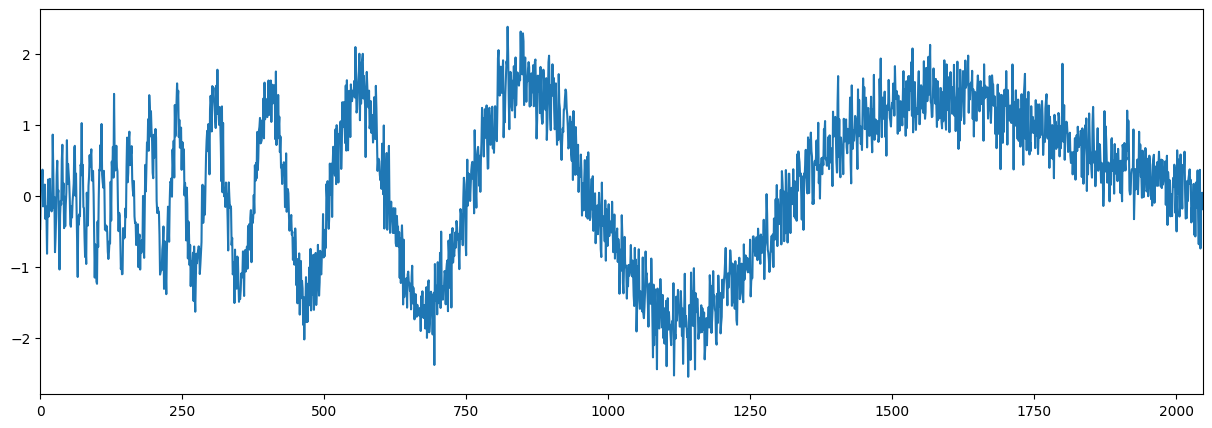

In [4]:
fig, ax = fig_ax()
ax.plot(signal_question_4)
plt.plot()